In [ ]:
# SELECT DISTINCT ?image ?date ?car ?carLabel ?brandLabel 
# WHERE {
#   ?car wdt:P31 wd:Q850270;     
#        wdt:P18 ?image;      
#        wdt:P571 ?date;
#        wdt:P176 ?brand;     
#        rdfs:label ?carLabel.
  
#   ?brand rdfs:label ?brandLabel.
  
#   FILTER(LANG(?carLabel) = "fr" && LANG(?brandLabel) = "fr")
# }

# Collecte de données & Étiquetage et annotation

In [4]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import os
import requests

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?image ?date ?car ?carLabel ?brandLabel 
WHERE {
  ?car wdt:P31 wd:Q850270;     
       wdt:P18 ?image;      
       wdt:P571 ?date;
       wdt:P176 ?brand;     
       rdfs:label ?carLabel.
  
  ?brand rdfs:label ?brandLabel.
  
  FILTER(LANG(?carLabel) = "fr" && LANG(?brandLabel) = "fr")
}
LIMIT 100
"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)

conceptcars = []

for result in results["results"]["bindings"]:
    conceptcars.append({
        "image": result["image"]["value"],
        "date": result["date"]["value"],
        "car": result["car"]["value"],
        "carLabel": result["carLabel"]["value"],
        "brandLabel": result["brandLabel"]["value"]
    })

for conceptcar in conceptcars:
    conceptcar["carLabel"] = conceptcar["carLabel"].replace("\\", "")
    conceptcar["carLabel"] = conceptcar["carLabel"].replace("/", "")
                                              
with open('conceptcars.json', 'w', encoding='utf-8') as f:
    json.dump(conceptcars, f, ensure_ascii=False, indent=4)


In [7]:
for filename in os.listdir("images"):
    os.remove(f"images/{filename}")
    
with open('conceptcars.json', 'r', encoding='utf-8') as f:
    conceptcars = json.load(f)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
}

n = 0

for car in conceptcars:
    image_url = car["image"]
    n = n + 1
    r = requests.get(image_url, allow_redirects=True, headers=headers)
    image_url = r.url  

    car_name = car.get("carLabel", "Image n°" + str(n))
    
    image_data = r.content 
    with open(f'images/{car_name}.jpg', 'wb') as f:
        f.write(image_data)

In [68]:
import os
import json
from PIL import Image as PILImage
from PIL.ExifTags import TAGS
import numpy as np
from sklearn.cluster import KMeans
import ipywidgets as widgets
from IPython.display import display, clear_output

class ImageTaggerApp:
    def __init__(self, images_dir, metadata_dir):
        # Configuration des répertoires
        self.images_dir = images_dir
        self.metadata_dir = metadata_dir
        os.makedirs(metadata_dir, exist_ok=True)
        
        # Charger les images
        self.images = [os.path.join(images_dir, f) for f in os.listdir(images_dir) 
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if not self.images:
            print("Aucune image trouvée dans le dossier.")
            return
            
        # Définir les tags et initialiser les variables
        self.tags = ["Vintage", "Original", "Night Photo"]
        self.current_index = 0
        self.matrix = {}
        self.load_existing_metadata()
        
        # Création de l'application
        self.create_app()
        
    def create_app(self):
        """Crée l'application complète"""
        # Titre
        self.title = widgets.HTML("<h2 style='text-align: center;'>Tag selection</h2>")
        
        # Widget pour l'image
        self.image_widget = widgets.Image(
            format='jpg',
            width=400,
            height=400,
            layout=widgets.Layout(margin='0 auto')
        )
        
        # Label pour afficher le nom de l'image
        self.image_label = widgets.Label(
            value=f"Image {self.current_index + 1}/{len(self.images)}: {os.path.basename(self.images[self.current_index])}"
        )
        
        # Checkboxes pour les tags
        self.tag_checkboxes = [widgets.Checkbox(description=tag, value=False) for tag in self.tags]
        tag_box = widgets.VBox(
            self.tag_checkboxes, 
            layout=widgets.Layout(margin="10px", padding="10px", border="1px solid #ddd", border_radius="5px")
        )
        
        # Boutons de navigation
        self.prev_button = widgets.Button(description='Précédent', button_style="info")
        self.next_button = widgets.Button(description='Suivant', button_style="info")
        self.save_button = widgets.Button(description='Sauvegarder les Tags', button_style="primary")
        buttons = widgets.HBox(
            [self.prev_button, self.next_button, self.save_button], 
            layout=widgets.Layout(justify_content="center", padding="10px")
        )
        
        # Zone de sortie pour les messages
        self.output = widgets.Output()
        
        # Associer les événements
        self.prev_button.on_click(self.show_previous_image)
        self.next_button.on_click(self.show_next_image)
        self.save_button.on_click(self.save_tags)
        
        # Construire l'interface
        app_layout = widgets.VBox([
            self.title,
            self.image_widget,
            self.image_label,
            tag_box,
            buttons,
            self.output
        ], layout=widgets.Layout(align_items="center"))
        
        # Afficher l'interface
        display(app_layout)
        
        # Initialiser l'affichage de l'image et des tags
        self.update_image()
        self.set_tags()
    
    def load_existing_metadata(self):
        """Charge les métadonnées existantes pour chaque image"""
        for img_path in self.images:
            json_filename = os.path.splitext(os.path.basename(img_path))[0] + ".json"
            json_path = os.path.join(self.metadata_dir, json_filename)
            
            if os.path.exists(json_path):
                with open(json_path, 'r', encoding='utf-8') as f:
                    metadata = json.load(f)
                    tags = metadata.get("tags", [])
                    tag_values = {
                        "Vintage": "isVintage" in tags,
                        "Original": "isOriginal" in tags,
                        "Night Photo": "isNightPicture" in tags
                    }
                    self.matrix[img_path] = {
                        "tag_values": tag_values,
                        "metadata": metadata
                    }
            else:
                # Extraire les métadonnées pour les nouvelles images
                self.matrix[img_path] = {
                    "tag_values": {tag: False for tag in self.tags},
                    "metadata": self.extract_metadata(img_path)
                }
    
    def extract_metadata(self, img_path):
        """Extrait les métadonnées et les couleurs dominantes d'une image"""
        with PILImage.open(img_path) as img:
            metadata = {
                "format": img.format,
                "size": img.size,
                "mode": img.mode,
                "orientation": "Landscape" if img.width > img.height else "Portrait" if img.height > img.width else "Square",
                "camera_model": None,  
                "date_taken": None,
                "colors": None,
                "tags": []
            }

            # Extraction des données EXIF
            exif_data = img._getexif()
            if exif_data:
                exif_info = {TAGS.get(tag, tag): value for tag, value in exif_data.items()}
                metadata["camera_model"] = exif_info.get("Model", None)
                metadata["date_taken"] = exif_info.get("DateTimeOriginal", None)

            # Extraction des couleurs dominantes
            try:
                img_data = np.array(img.convert("RGB").getdata())
                kmeans = KMeans(n_clusters=4, random_state=0).fit(img_data)
                colors = kmeans.cluster_centers_.astype(int).tolist()
                metadata["colors"] = colors
            except Exception as e:
                print(f"Erreur lors de l'extraction des couleurs pour {os.path.basename(img_path)}: {e}")
                metadata["colors"] = None
                
            return metadata

    def update_image(self):
        """Met à jour l'image affichée"""
        img_path = self.images[self.current_index]
        
        # Ouvrir et redimensionner l'image
        with PILImage.open(img_path) as img:
            # Redimensionnement pour un affichage optimal
            max_height = 400
            if img.height > max_height:
                ratio = max_height / img.height
                new_width = int(img.width * ratio)
                img = img.resize((new_width, max_height))
            
            # Convertir en format pour widgets.Image
            import io
            buf = io.BytesIO()
            img.save(buf, format='JPEG')
            img_data = buf.getvalue()
        
        # Mettre à jour le widget d'image
        self.image_widget.value = img_data
        
        # Mettre à jour le label
        self.image_label.value = f"Image {self.current_index + 1}/{len(self.images)}: {os.path.basename(img_path)}"

    def set_tags(self):
        """Définit l'état des cases à cocher en fonction des tags existants"""
        img_path = self.images[self.current_index]
        
        if img_path in self.matrix:
            tag_values = self.matrix[img_path]["tag_values"]
            for i, tag in enumerate(self.tags):
                self.tag_checkboxes[i].value = tag_values.get(tag, False)

    def show_previous_image(self, _):
        """Passe à l'image précédente"""
        self.update_current_tags()
        self.current_index = (self.current_index - 1) % len(self.images)
        self.update_image()
        self.set_tags()

    def show_next_image(self, _):
        """Passe à l'image suivante"""
        self.update_current_tags()
        self.current_index = (self.current_index + 1) % len(self.images)
        self.update_image()
        self.set_tags()

    def update_current_tags(self):
        """Met à jour les tags pour l'image actuelle"""
        img_path = self.images[self.current_index]
        
        tag_values = {}
        for i, checkbox in enumerate(self.tag_checkboxes):
            tag_values[self.tags[i]] = checkbox.value
            
        if img_path in self.matrix:
            self.matrix[img_path]["tag_values"] = tag_values
        else:
            metadata = self.extract_metadata(img_path)
            self.matrix[img_path] = {
                "tag_values": tag_values,
                "metadata": metadata
            }

    def save_tags(self, _):
        """Sauvegarde les tags de toutes les images"""
        with self.output:
            clear_output()
            self.update_current_tags()
            
            for img_path, data in self.matrix.items():
                json_filename = os.path.splitext(os.path.basename(img_path))[0] + ".json"
                json_path = os.path.join(self.metadata_dir, json_filename)
                
                metadata = data["metadata"]
                tag_values = data["tag_values"]
                
                # Convertir les valeurs de checkbox en tags formatés
                tags = []
                if tag_values.get("Vintage", False):
                    tags.append("isVintage")
                if tag_values.get("Original", False):
                    tags.append("isOriginal")
                if tag_values.get("Night Photo", False):
                    tags.append("isNightPicture")
                
                metadata["tags"] = list(set(tags))
                
                with open(json_path, "w", encoding="utf-8") as f:
                    json.dump(metadata, f, indent=4, ensure_ascii=False)
                
def main():
    images_dir = "images"
    metadata_dir = "metadata"
    app = ImageTaggerApp(images_dir, metadata_dir)

if __name__ == "__main__":
    main()

### Visualisation des tags / couleur prédominant

In [67]:
import os
import json
from PIL import Image as PILImage
from PIL.ExifTags import TAGS
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

class ImageVisualizationApp:
    def __init__(self, images_dir, metadata_dir):
        """
        Initialise l'application de visualisation d'images
        
        Args:
            images_dir: Répertoire contenant les images
            metadata_dir: Répertoire contenant les métadonnées
        """
        # Configuration des répertoires
        self.images_dir = images_dir
        self.metadata_dir = metadata_dir
        
        # Charger les chemins des images
        self.images = [os.path.join(images_dir, f) for f in os.listdir(images_dir) 
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if not self.images:
            print("Aucune image trouvée dans le dossier.")
            return
            
        # Variables de l'interface
        self.current_index = 0
        
        # Charger les métadonnées
        self.load_metadata()
        
        # Créer l'interface
        self.create_ui()
    
    def load_metadata(self):
        """Charge les métadonnées des images depuis les fichiers JSON"""
        self.metadata = {}
        
        for img_path in self.images:
            base_name = os.path.basename(img_path)
            json_filename = os.path.splitext(base_name)[0] + ".json"
            json_path = os.path.join(self.metadata_dir, json_filename)
            
            if os.path.exists(json_path):
                with open(json_path, 'r', encoding='utf-8') as f:
                    self.metadata[base_name] = json.load(f)
            else:
                print(f"Pas de métadonnées trouvées pour {base_name}")
                self.metadata[base_name] = None
    
    def create_ui(self):
        """Crée l'interface utilisateur de l'application"""
        # Titre
        self.title = widgets.HTML("<h2 style='text-align: center;'>Visualisation des images</h2>")
        
        # Widget pour l'image
        self.image_widget = widgets.Image(
            format='jpg',
            width=600,
            height=600,
            layout=widgets.Layout(margin='0 auto')
        )
        
        # Widget pour le nom de l'image
        self.image_label = widgets.Label(
            value=f"Image {self.current_index + 1}/{len(self.images)}: {os.path.basename(self.images[self.current_index])}"
        )
        
        # Widgets pour les informations
        self.tags_label = widgets.Label(value=self.get_tags())
        self.orientation_label = widgets.Label(value=self.get_orientation())
        self.color_widget = widgets.HTML(value=self.get_color_html())
        
        # Boutons de navigation
        self.prev_button = widgets.Button(description='Précédent', button_style="info")
        self.next_button = widgets.Button(description='Suivant', button_style="info")
        self.finish_button = widgets.Button(description='Terminer', button_style="danger")
        
        # Événements des boutons
        self.prev_button.on_click(self.show_previous_image)
        self.next_button.on_click(self.show_next_image)
        self.finish_button.on_click(self.finish)
        
        # Mise en page
        info_box = widgets.VBox([
            self.tags_label,
            self.orientation_label,
            self.color_widget
        ], layout=widgets.Layout(
            margin="10px",
            padding="10px",
            border="1px solid #ddd",
            border_radius="5px"
        ))
        
        buttons = widgets.HBox(
            [self.prev_button, self.next_button, self.finish_button],
            layout=widgets.Layout(justify_content="center", padding="10px")
        )
        
        # Construction finale
        app_layout = widgets.VBox([
            self.title,
            self.image_widget,
            self.image_label,
            info_box,
            buttons
        ], layout=widgets.Layout(align_items="center"))
        
        # Afficher l'interface
        display(app_layout)
        
        # Mettre à jour l'image
        self.update_image()
    
    def update_image(self):
        """Met à jour l'image affichée"""
        img_path = self.images[self.current_index]
        
        # Ouvrir et redimensionner l'image
        with PILImage.open(img_path) as img:
            # Redimensionnement pour un affichage optimal
            height = 600
            if img.height > 0:
                img = img.resize((int(img.width * (height / img.height)), height))
            
            # Convertir en format pour widgets.Image
            import io
            buf = io.BytesIO()
            img.save(buf, format='JPEG')
            img_data = buf.getvalue()
        
        # Mettre à jour le widget d'image
        self.image_widget.value = img_data
        
        # Mettre à jour le label
        self.image_label.value = f"Image {self.current_index + 1}/{len(self.images)}: {os.path.basename(img_path)}"
    
    def update_info(self):
        """Met à jour les informations affichées"""
        self.tags_label.value = self.get_tags()
        self.orientation_label.value = self.get_orientation()
        self.color_widget.value = self.get_color_html()
    
    def get_tags(self):
        """Récupère les tags de l'image courante"""
        img_path = self.images[self.current_index]
        base_name = os.path.basename(img_path)
        
        if base_name in self.metadata and self.metadata[base_name] is not None:
            metadata = self.metadata[base_name]
            tags = metadata.get("tags", [])
            
            if tags:
                return "Tags : " + ", ".join(tags)
        
        return "Tags : aucun"
    
    def get_orientation(self):
        """Récupère l'orientation de l'image courante"""
        img_path = self.images[self.current_index]
        base_name = os.path.basename(img_path)
        
        if base_name in self.metadata and self.metadata[base_name] is not None:
            metadata = self.metadata[base_name]
            orientation = metadata.get("orientation", "")
            
            if orientation:
                return f"Orientation : {orientation}"
        
        return "Orientation : inconnue"
    
    def get_color_html(self):
        """Génère le HTML pour afficher les couleurs dominantes"""
        img_path = self.images[self.current_index]
        base_name = os.path.basename(img_path)
        
        if base_name in self.metadata and self.metadata[base_name] is not None:
            metadata = self.metadata[base_name]
            colors = metadata.get("colors", [])
            
            if colors and len(colors) > 0:
                html = "<div style='display: flex; gap: 5px;'>"
                for color in colors[:4]:  # Prendre jusqu'à 4 couleurs
                    html += f"<div style='width: 30px; height: 30px; background-color: rgb({color[0]}, {color[1]}, {color[2]});'></div>"
                html += "</div>"
                return html
        
        return "<div>Pas de couleurs dominantes disponibles</div>"
    
    def show_next_image(self, _):
        """Affiche l'image suivante"""
        self.current_index = (self.current_index + 1) % len(self.images)
        self.update_image()
        self.update_info()
    
    def show_previous_image(self, _):
        """Affiche l'image précédente"""
        self.current_index = (self.current_index - 1) % len(self.images)
        self.update_image()
        self.update_info()
    
    def finish(self, _):
        """Termine l'application"""
        clear_output()
        print("Visualisation terminée.")

def main():
    images_dir = "images"
    metadata_dir = "metadata"
    app = ImageVisualizationApp(images_dir, metadata_dir)

if __name__ == "__main__":
    main()

# Analyses de données

In [62]:
import os
import json
import random
from collections import Counter
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import random

def get_user_image_selection(num_images=3):
    available_images = os.listdir(images_dir)
    selected_images = random.sample(available_images, min(num_images, len(available_images)))
    
    image_tags = {}
    for img in selected_images:
        tags = random.sample(["isVintage", "isOriginal", "isNightPicture"], 2)
        image_tags[img] = tags
    
    return image_tags

def build_user_profile(selected_images):
    profile = {
        "preferred_colors": [],
        "preferred_orientation": [],
        "preferred_sizes": [],
        "favorite_tags": []
    }
    
    for img in selected_images:
        metadata_path = os.path.join(metadata_dir, f"{img.split('.')[0]}.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                
            profile["preferred_colors"].extend(metadata["colors"])
            profile["preferred_orientation"].append(metadata["orientation"])

            width, height = metadata["size"]
            size_category = "thumbnail" if width < 500 else "medium" if width < 1000 else "large"
            profile["preferred_sizes"].append(size_category)
            
            profile["favorite_tags"].extend(selected_images[img])
    
    profile["preferred_colors"] = np.mean(profile["preferred_colors"], axis=0).tolist()
    profile["preferred_orientation"] = Counter(profile["preferred_orientation"]).most_common(1)[0][0]
    profile["preferred_sizes"] = Counter(profile["preferred_sizes"]).most_common(1)[0][0]
    profile["favorite_tags"] = list(set(profile["favorite_tags"]))[:3] 
    
    return profile

def enhance_image_data(metadata):
    colors = np.array(metadata["colors"])
    if len(colors) >= 3:  
        kmeans = KMeans(n_clusters=2, random_state=42).fit(colors)
        metadata["color_clusters"] = kmeans.labels_.tolist()
    
    color_variance = np.var(colors, axis=0).mean()
    metadata["color_complexity"] = float(color_variance)
    
    return metadata

def create_random_users(num_users=5):
    users = {}
    for i in range(num_users):
        user_id = f"user_{i+1}"
        selected_images = get_user_image_selection()
        profile = build_user_profile(selected_images)
        users[user_id] = {
            "selected_images": selected_images,
            "profile": profile
        }
    
    return users

def analyze_users(users):
    all_colors = []
    all_sizes = []
    all_tags = []
    
    for user_id, data in users.items():
        all_colors.append(data["profile"]["preferred_colors"])
        all_sizes.append(data["profile"]["preferred_sizes"])
        all_tags.extend(data["profile"]["favorite_tags"])
    
    avg_color = np.mean(all_colors, axis=0)
    most_common_size = Counter(all_sizes).most_common(1)[0][0]
    top_tags = [tag for tag, count in Counter(all_tags).most_common(3)]
    
    return {
        "average_preferred_color": avg_color.tolist(),
        "most_common_size": most_common_size,
        "top_tags": top_tags
    }

users = create_random_users(5)
print("Utilisateurs créés :", len(users))
print("\nExemple de profil utilisateur :")
print(json.dumps(users["user_1"], indent=2))
analysis = analyze_users(users)
print("\nAnalyse globale :")
print(json.dumps(analysis, indent=2))

Utilisateurs créés : 5

Exemple de profil utilisateur :
{
  "selected_images": {
    "Audi Le Mans Quattro.jpg": [
      "isOriginal",
      "isNightPicture"
    ],
    "Mercedes-Benz ConceptFascination.jpg": [
      "isOriginal",
      "isNightPicture"
    ],
    "Peugeot H2O.jpg": [
      "isNightPicture",
      "isOriginal"
    ]
  },
  "profile": {
    "preferred_colors": [
      122.33333333333333,
      126.0,
      132.0
    ],
    "preferred_orientation": "Landscape",
    "preferred_sizes": "large",
    "favorite_tags": [
      "isNightPicture",
      "isOriginal"
    ]
  }
}

Analyse globale :
{
  "average_preferred_color": [
    118.95,
    114.61666666666667,
    116.11666666666667
  ],
  "most_common_size": "large",
  "top_tags": [
    "isNightPicture",
    "isOriginal",
    "isVintage"
  ]
}


- Création des utilisateurs aléatoires : J’ai simulé 5 utilisateurs avec des sélections d’images aléatoires du dossier /images et des tags générés aléatoirement.
- Nombre d’utilisateurs : 5.
- Informations stockées : Pour chaque utilisateur, les images sélectionnées (avec tags) et un profil (couleurs préférées, orientation, tailles, tags favoris).
- Analyses effectuées : Couleur moyenne préférée, taille d’image la plus courante, top tags globaux via des statistiques (moyennes, fréquences).

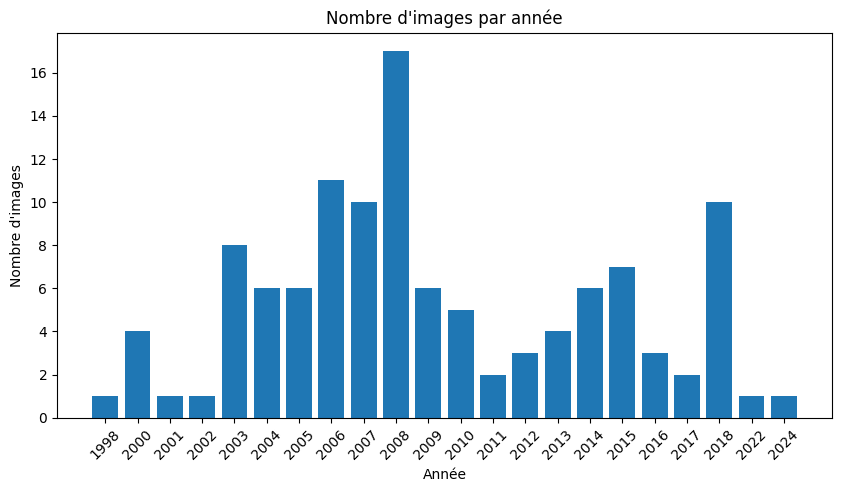

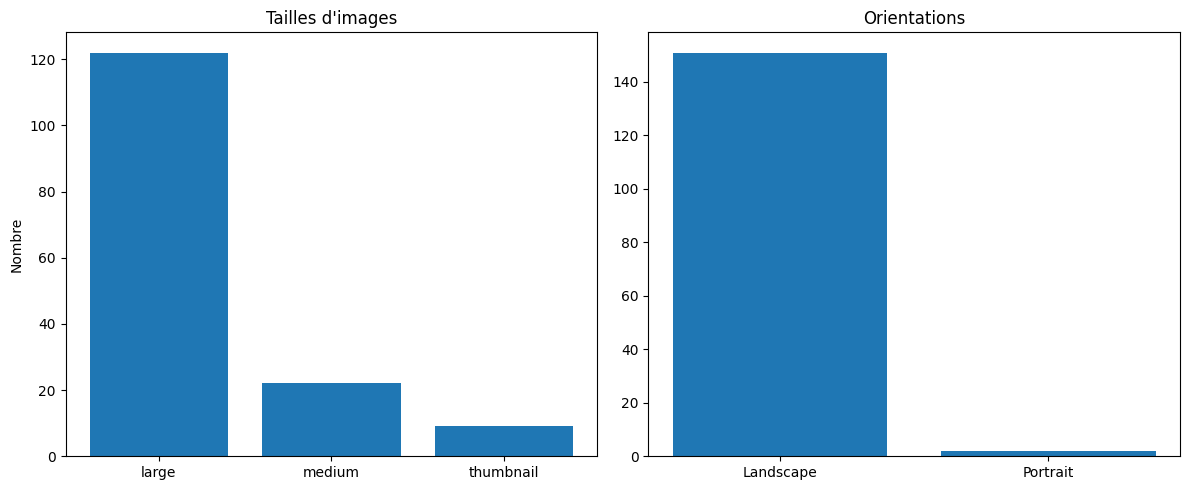

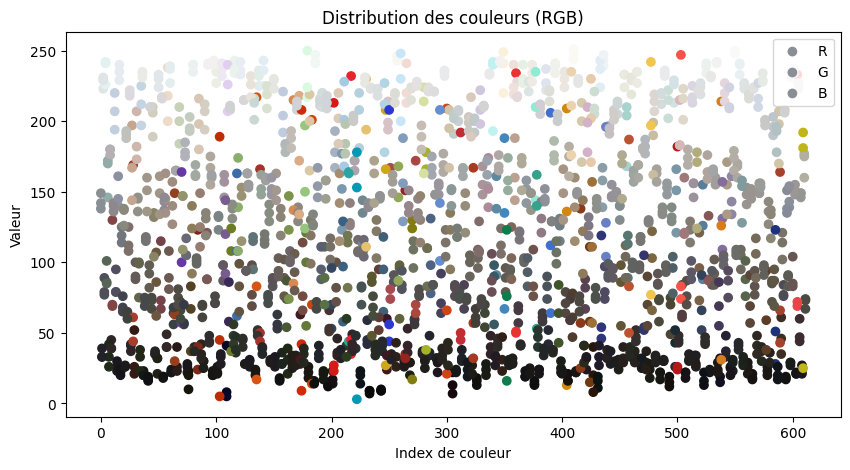

In [63]:
def load_all_metadata():
    metadata_list = []
    for file in os.listdir(metadata_dir):
        if file.endswith(".json"):
            with open(os.path.join(metadata_dir, file), 'r') as f:
                metadata_list.append(json.load(f))
    return metadata_list

# Simuler la création d'utilisateurs
def create_random_users(num_users=1):
    all_images = [f.split('.')[0] for f in os.listdir("images") if f.endswith(('.jpg', '.png', '.jpeg'))]
    users = {}
    for i in range(num_users):
        user_id = f"user_{i+1}"
        selected_images = {img: random.sample(["nature", "portrait"], 2) for img in random.sample(all_images, min(2, len(all_images)))}
        profile = {
            "preferred_colors": [random.randint(0, 255) for _ in range(3)],
            "preferred_orientation": "Landscape",
            "preferred_sizes": "medium",
            "favorite_tags": ["nature", "portrait"]
        }
        users[user_id] = {"selected_images": selected_images, "profile": profile}
    return users

# 1. Images par année
def plot_images_by_year(metadata_list):
    years = [m["date_taken"].split(":")[0] for m in metadata_list 
             if "date_taken" in m and m["date_taken"] is not None and m["date_taken"].split(":")[0] != "0000"]
    if not years:
        print("Aucune donnée d'année valide disponible.")
        return
    
    year_counts = Counter(years)
    
    plt.figure(figsize=(10, 5))
    plt.bar(sorted(year_counts.keys()), [year_counts[year] for year in sorted(year_counts.keys())])
    plt.title("Nombre d'images par année")
    plt.xlabel("Année")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()

# 2. Types d'images
def plot_image_types(metadata_list):
    sizes = ["thumbnail" if m["size"][0] < 500 else "medium" if m["size"][0] < 1000 else "large" 
             for m in metadata_list]
    size_counts = Counter(sizes)
    
    orientations = [m["orientation"] for m in metadata_list 
                    if "orientation" in m and m["orientation"] is not None]
    orientation_counts = Counter(orientations)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.bar(size_counts.keys(), size_counts.values())
    ax1.set_title("Tailles d'images")
    ax1.set_ylabel("Nombre")
    
    ax2.bar(orientation_counts.keys(), orientation_counts.values())
    ax2.set_title("Orientations")
    
    plt.tight_layout()
    plt.show()

# 3. Caractéristiques des couleurs
def plot_color_characteristics(metadata_list):
    all_colors = [color for m in metadata_list for color in m["colors"] if color]
    if not all_colors:
        print("Aucune donnée de couleur disponible.")
        return
    colors_array = np.array(all_colors)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(colors_array)), colors_array[:, 0], c=colors_array/255, label="R")
    plt.scatter(range(len(colors_array)), colors_array[:, 1], c=colors_array/255, label="G")
    plt.scatter(range(len(colors_array)), colors_array[:, 2], c=colors_array/255, label="B")
    plt.title("Distribution des couleurs (RGB)")
    plt.xlabel("Index de couleur")
    plt.ylabel("Valeur")
    plt.legend()
    plt.show()


all_metadata = load_all_metadata()
plot_images_by_year(all_metadata)
plot_image_types(all_metadata)
plot_color_characteristics(all_metadata)

# Système de recommendation

## Basé sur le clustering

Chargement des métadonnées...
Métadonnées chargées pour 153 images
Extraction des caractéristiques...
Caractéristiques extraites pour 153 images
Clustering des images...
Visualisation des clusters...


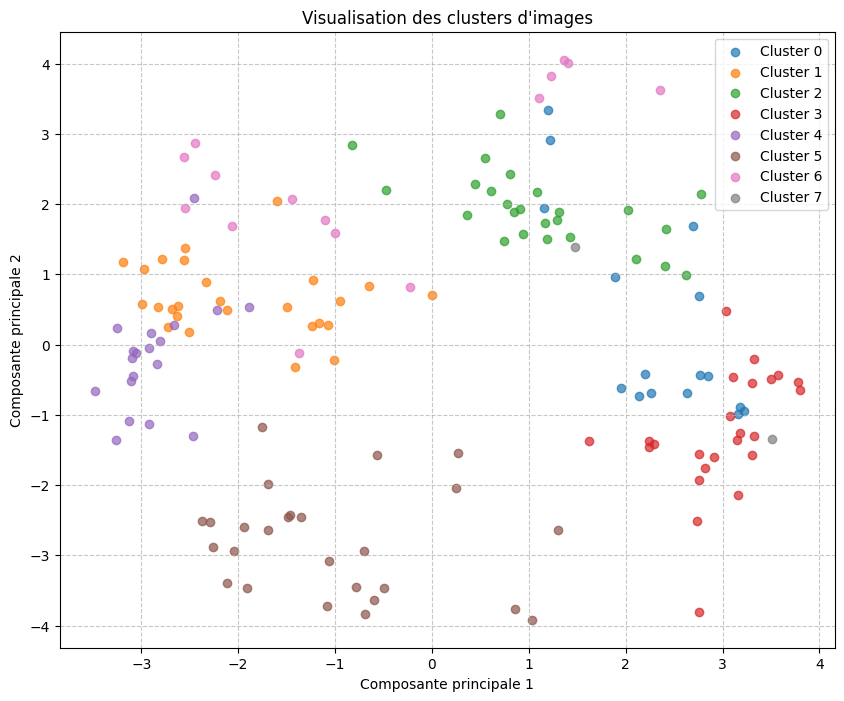

Construction du modèle de recommandation...
Création d'un utilisateur test...
Utilisateur test créé avec 2 images sélectionnées
Génération de recommandations...

Images sélectionnées par l'utilisateur:
- Maserati Chicane
- Volkswagen ID

Recommandations:
- Peugeot e-Legend
- Bizzarrini Ghepardo
- Dodge Copperhead


In [64]:
import os
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
import random

# Chemins des répertoires
images_dir = "images"
metadata_dir = "metadata"

def load_all_metadata():
    """Charge les métadonnées de toutes les images"""
    metadata_dict = {}
    for file in os.listdir(metadata_dir):
        if file.endswith(".json"):
            image_name = file.split('.')[0]
            file_path = os.path.join(metadata_dir, file)
            with open(file_path, 'r') as f:
                metadata_dict[image_name] = json.load(f)
    return metadata_dict

def extract_features(metadata):
    """
    Extrait les caractéristiques pertinentes des métadonnées pour le clustering
    """
    features = []
    image_names = []
    
    for name, data in metadata.items():
        if not data.get("colors"):
            continue
        
        # Extraire les caractéristiques des couleurs (aplaties)
        color_features = np.array(data["colors"]).flatten()
        
        # Caractéristiques d'orientation (one-hot encoding)
        orientation_feature = [0, 0, 0]  # [Landscape, Portrait, Square]
        if data.get("orientation") == "Landscape":
            orientation_feature[0] = 1
        elif data.get("orientation") == "Portrait":
            orientation_feature[1] = 1
        else:
            orientation_feature[2] = 1
        
        # Caractéristiques de taille
        width, height = data.get("size", [0, 0])
        size_features = [width, height, width * height]
        
        # Caractéristiques des tags (encodage binaire)
        tag_features = []
        all_possible_tags = ["isVintage", "isOriginal", "isNightPicture"]
        image_tags = data.get("tags", [])
        
        for tag in all_possible_tags:
            tag_features.append(1 if tag in image_tags else 0)
        
        # Combiner toutes les caractéristiques
        combined_features = np.concatenate([
            color_features, 
            orientation_feature, 
            size_features, 
            tag_features
        ])
        
        features.append(combined_features)
        image_names.append(name)
    
    return np.array(features), image_names

def cluster_images(features, n_clusters=8):
    """
    Regroupe les images en clusters basés sur leurs caractéristiques
    """
    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    
    # Application de KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(normalized_features)
    
    return cluster_labels, normalized_features, scaler

def build_recommendation_model(normalized_features):
    """
    Construit un modèle de voisins les plus proches pour les recommandations
    """
    model = NearestNeighbors(n_neighbors=5, algorithm='auto')
    model.fit(normalized_features)
    return model

def get_user_profile_features(user_profile, metadata, scaler):
    """
    Convertit le profil utilisateur en un vecteur de caractéristiques compatible
    """
    # Préparer les caractéristiques des images aimées par l'utilisateur
    selected_images = user_profile["selected_images"].keys()
    features_list = []
    
    for img_name in selected_images:
        img_name_no_ext = img_name.split('.')[0]
        if img_name_no_ext in metadata:
            data = metadata[img_name_no_ext]
            
            if not data.get("colors"):
                continue
                
            # Extraire les caractéristiques comme précédemment
            color_features = np.array(data["colors"]).flatten()
            
            orientation_feature = [0, 0, 0]
            if data.get("orientation") == "Landscape":
                orientation_feature[0] = 1
            elif data.get("orientation") == "Portrait":
                orientation_feature[1] = 1
            else:
                orientation_feature[2] = 1
            
            width, height = data.get("size", [0, 0])
            size_features = [width, height, width * height]
            
            tag_features = []
            all_possible_tags = ["isVintage", "isOriginal", "isNightPicture"]
            image_tags = data.get("tags", [])
            
            for tag in all_possible_tags:
                tag_features.append(1 if tag in image_tags else 0)
            
            combined_features = np.concatenate([
                color_features, 
                orientation_feature, 
                size_features, 
                tag_features
            ])
            
            features_list.append(combined_features)
    
    if not features_list:
        return None
        
    # Moyenne des caractéristiques des images aimées
    user_features = np.mean(features_list, axis=0)
    
    # Normaliser avec le même scaler que les images
    normalized_user_features = scaler.transform([user_features])
    
    return normalized_user_features

def recommend_images(user_profile, metadata, nn_model, image_names, scaler, n_recommendations=5):
    """
    Recommande des images à un utilisateur en fonction de son profil
    """
    # Obtenir les caractéristiques du profil utilisateur
    user_features = get_user_profile_features(user_profile, metadata, scaler)
    
    if user_features is None:
        print("Impossible de générer des recommandations : aucune caractéristique d'image valide")
        return []
    
    # Trouver les images les plus similaires
    distances, indices = nn_model.kneighbors(user_features)
    
    # Convertir les indices en noms d'images
    recommended_images = [image_names[idx] for idx in indices[0]]
    
    # Filtrer les images déjà sélectionnées par l'utilisateur
    selected_images = [img.split('.')[0] for img in user_profile["selected_images"].keys()]
    recommended_images = [img for img in recommended_images if img not in selected_images]
    
    # Limiter le nombre de recommandations
    return recommended_images[:n_recommendations]

def visualize_clusters(features, labels, image_names):
    """
    Visualise les clusters d'images en 2D (réduction de dimensionnalité)
    """
    from sklearn.decomposition import PCA
    
    # Réduction à 2 dimensions pour la visualisation
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)
    
    # Créer un graphique coloré par cluster
    plt.figure(figsize=(10, 8))
    
    # Nombre de clusters
    n_clusters = len(set(labels))
    
    # Tracer chaque cluster avec une couleur différente
    for i in range(n_clusters):
        plt.scatter(
            features_2d[labels == i, 0], 
            features_2d[labels == i, 1],
            label=f"Cluster {i}",
            alpha=0.7
        )
    
    plt.title("Visualisation des clusters d'images")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def main():
    # Charger les données
    print("Chargement des métadonnées...")
    metadata = load_all_metadata()
    print(f"Métadonnées chargées pour {len(metadata)} images")
    
    # Extraire les caractéristiques
    print("Extraction des caractéristiques...")
    features, image_names = extract_features(metadata)
    print(f"Caractéristiques extraites pour {len(features)} images")
    
    # Clustering des images
    print("Clustering des images...")
    n_clusters = min(8, len(features))  # Ajustement du nombre de clusters selon les données
    cluster_labels, normalized_features, scaler = cluster_images(features, n_clusters)
    
    # Visualiser les clusters
    print("Visualisation des clusters...")
    visualize_clusters(normalized_features, cluster_labels, image_names)
    
    # Construire le modèle de recommandation
    print("Construction du modèle de recommandation...")
    nn_model = build_recommendation_model(normalized_features)
    
    # Créer un utilisateur test
    print("Création d'un utilisateur test...")
    test_user = create_random_users(1)["user_1"]
    print(f"Utilisateur test créé avec {len(test_user['selected_images'])} images sélectionnées")
    
    # Obtenir des recommandations
    print("Génération de recommandations...")
    recommendations = recommend_images(test_user, metadata, nn_model, image_names, scaler)
    
    print("\nImages sélectionnées par l'utilisateur:")
    for img in test_user["selected_images"].keys():
        print(f"- {img}")
    
    print("\nRecommandations:")
    for img in recommendations:
        print(f"- {img}")
    
    return recommendations, test_user

if __name__ == "__main__":
    main()

## Sans clustering

In [65]:
import os
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def load_user_profile(user_id, users):
    """Charger le profil d'un utilisateur spécifique"""
    if user_id in users:
        return users[user_id]["profile"]
    else:
        print(f"Utilisateur {user_id} non trouvé")
        return None

def load_all_image_metadata():
    """Charger les métadonnées de toutes les images"""
    all_metadata = {}
    for file in os.listdir(metadata_dir):
        if file.endswith(".json"):
            image_id = file.split('.')[0]
            with open(os.path.join(metadata_dir, file), 'r') as f:
                all_metadata[image_id] = json.load(f)
    return all_metadata

def extract_features(metadata):
    """Extraire des caractéristiques des métadonnées pour la recommandation"""
    features = []
    
    # Caractéristiques des couleurs
    if metadata.get("colors") and len(metadata["colors"]) > 0:
        # Calculer la moyenne des couleurs
        colors = np.array(metadata["colors"])
        avg_color = np.mean(colors, axis=0)
        features.extend(avg_color)
    else:
        features.extend([0, 0, 0])  # Valeurs par défaut
    
    # Orientation (encodage one-hot)
    orientation = metadata.get("orientation", "Landscape")
    if orientation == "Landscape":
        features.extend([1, 0, 0])
    elif orientation == "Portrait":
        features.extend([0, 1, 0])
    else:  # Square
        features.extend([0, 0, 1])
    
    # Taille (transformée en catégorie)
    width, height = metadata.get("size", (0, 0))
    if width < 500:
        features.extend([1, 0, 0])  # Thumbnail
    elif width < 1000:
        features.extend([0, 1, 0])  # Medium
    else:
        features.extend([0, 0, 1])  # Large
    
    # Caractéristiques des tags
    tags = metadata.get("tags", [])
    has_vintage = 1 if "isVintage" in tags else 0
    has_original = 1 if "isOriginal" in tags else 0
    has_night = 1 if "isNightPicture" in tags else 0
    
    features.extend([has_vintage, has_original, has_night])
    
    return np.array(features)

def extract_user_preferences(profile):
    """Extraire les préférences d'un utilisateur sous forme de vecteur"""
    features = []
    
    # Préférences de couleurs
    if profile.get("preferred_colors"):
        features.extend(profile["preferred_colors"])
    else:
        features.extend([0, 0, 0])
    
    # Préférence d'orientation
    orientation = profile.get("preferred_orientation", "Landscape")
    if orientation == "Landscape":
        features.extend([1, 0, 0])
    elif orientation == "Portrait":
        features.extend([0, 1, 0])
    else:  # Square
        features.extend([0, 0, 1])
    
    # Préférence de taille
    size_pref = profile.get("preferred_sizes", "medium")
    if size_pref == "thumbnail":
        features.extend([1, 0, 0])
    elif size_pref == "medium":
        features.extend([0, 1, 0])
    else:  # large
        features.extend([0, 0, 1])
    
    # Préférences de tags
    tags = profile.get("favorite_tags", [])
    has_vintage = 1 if "isVintage" in tags else 0
    has_original = 1 if "isOriginal" in tags else 0
    has_night = 1 if "isNightPicture" in tags else 0
    
    features.extend([has_vintage, has_original, has_night])
    
    return np.array(features)

def recommend_images(user_id, users, top_n=5):
    """Recommander des images à un utilisateur basé sur son profil"""
    user_profile = load_user_profile(user_id, users)
    if not user_profile:
        return []
    
    all_metadata = load_all_image_metadata()
    
    # Extraire les caractéristiques pour toutes les images
    image_features = {}
    for image_id, metadata in all_metadata.items():
        image_features[image_id] = extract_features(metadata)
    
    # Extraire les préférences de l'utilisateur
    user_preferences = extract_user_preferences(user_profile)
    
    # Normaliser les caractéristiques
    all_features = np.array(list(image_features.values()))
    scaler = StandardScaler()
    
    if len(all_features) > 0:
        scaled_features = scaler.fit_transform(all_features)
        scaled_user_preferences = scaler.transform(user_preferences.reshape(1, -1))
        
        # Calculer la similarité cosinus entre les préférences de l'utilisateur et chaque image
        similarities = cosine_similarity(scaled_user_preferences, scaled_features)[0]
        
        # Créer un dictionnaire d'images avec leurs scores de similarité
        image_scores = {image_id: similarities[i] for i, image_id in enumerate(image_features.keys())}
        
        # Trier les images par score de similarité décroissant
        sorted_images = sorted(image_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Filtrer les images déjà vues par l'utilisateur
        seen_images = set(users[user_id]["selected_images"].keys())
        
        # Retourner les N meilleures recommandations non vues
        recommendations = []
        for image_id, score in sorted_images:
            if image_id not in seen_images and len(recommendations) < top_n:
                recommendations.append((image_id, score))
        
        return recommendations
    else:
        return []

# Test du système de recommandation
users = create_random_users(5)
for user_id in users.keys():
    recommendations = recommend_images(user_id, users)
    print(f"Recommandations pour {user_id}:")
    for image_id, score in recommendations:
        print(f"  - {image_id} (score: {score:.4f})")

Recommandations pour user_1:
  - Audi Roadjet (score: 0.7166)
  - Volkswagen GX3 (score: 0.6758)
  - Lamborghini Flying Star II (score: 0.6233)
  - Volkswagen Futura (score: 0.6232)
  - Audi Le Mans Quattro (score: 0.6145)
Recommandations pour user_2:
  - Chrysler ME Four-Twelve (score: 0.7784)
  - Lamborghini Flying Star II (score: 0.7753)
  - Audi Roadjet (score: 0.7539)
  - Hyundai Clix (score: 0.7290)
  - Mercedes-Benz F200 (score: 0.6384)
Recommandations pour user_3:
  - Lamborghini Pregunta (score: 0.6911)
  - Maserati Medici (score: 0.6877)
  - Saab 92001 (score: 0.6691)
  - Chrysler Atlantic (score: 0.6518)
  - Fiat Panda II H2 (score: 0.6141)
Recommandations pour user_4:
  - Saab 92001 (score: 0.6871)
  - Opel GTC Concept (score: 0.6800)
  - Porsche Type 64 (score: 0.6397)
  - Chrysler Firepower (score: 0.6171)
  - Subaru B9 Scrambler (score: 0.5964)
Recommandations pour user_5:
  - Chrysler ME Four-Twelve (score: 0.6224)
  - BMW E1 (score: 0.5548)
  - Mazda HR-X (score: 0.475